# Assignment 2 - Differential Equations

Solving partial differential equations is crucial to a huge variety of physical problems encountered in science and engineering. There are many different numerical techniques available, all with their own advantages and disadvantages, and often specific problems are best solved with very specific algorithms.

You will have learnt about Euler and Runge-Kutta methods in 2nd year lectures, and you should have explored the class of problem that can be solved with numerical integration in exercises.  In this assignment, we will cover more complex classes of problem - described below.


## Initial value problems

In this class of problem, the state of a system is fully described by an ordinary differential equation together with an initial condition.  For example, the motion of a body under gravity, with initial conditions given by the position and momentum of the body at a particular point in time.  The soluiton (ie. position and momentum at an arbitrary time in the future) can then be found by integration.  You should have encountered the use of numerical integration in solving such problems in the 2nd year course.

## Boundary value problems

Boundary value problems differ in that the conditions are specified on a set of boundaries, rather than at just one extreme.  For example, the electric field between a pair of capacitor plates at fixed potential, as discussed in the problem below.

There are several numerical approaches for solving boundary value problems, for example :

### Shooting Method

In this method, the boundary value problem is reduced to an initial value problem, which is solved numerically for different parameter choices. A solution is found when a set of parameters give the desired boundary conditions.  For example, finding a rocket trajectory which joins two specified points in space.  The boundary conditions are the specified points, and the initial momentum is a parameter that may be varied until a solution is found.  (This should sound familiar!)

### Finite Difference Methods

In this class of method, the differential equation is evaluated at discrete points in space and time, and derivatives are approximated by finite differences.  The Euler and Runga-Kutta methods are simple examples.  These methods typically involve iteration on the set of finite values until a solution is found.

### Relaxation

This is a common technique used to solve time-independent boundary condition problems.  An initial guess at the solution is supplied, and then allow to "relax" by iterating towards the final solution.  Conceptually this is is the same as the time-dependent problem of letting the system reach equilibrium from some arbitrary initial state.

The steps for implementing a relaxation method are :
1. Define a (normally regular) spatial grid covering the region of interest including points (or “nodes”) on the boundaries
2. Impose the boundary conditions by fixing the nodes on the boundaries to the relevant values
3. Set all non-boundary nodes to an initial guess
4. Write down finite difference equations
5. Pick a convergence criterion
6. Iterate the equations at each node until the solution converges

Care must be taken to choose the form of the equations and iteration method to ensure stability and efficiency.

## Q1 - The Poisson Equation

Consider the example of the Poisson equation $(\nabla^2V = −\rho)$ in one dimension. The grid of nodes in this case can be taken as a series of $n$ equally spaced points $x_i$ with a spacing $\Delta x = h$. The Taylor expansion of $V$ around the point $x_i$ is :

$$ V(x) = V(x_i) + \delta x \frac{dV(x_i)}{dx} + \delta x^2 \frac{d^2V(x_i)}{dx^2} + ...$$

so adding the values at $\delta x = \pm h$ (i.e. at $x_n \pm 1$) gives :

$$ V(x_{i−1}) + V(x_{i+1}) = 2V(x_i) + h^2 \frac{d^2V(x_i)}{dx^2} $$

which can be rearranged to give Equation 1 :

$$ \frac{d^2V(x_i)}{dx^2} = \frac{V(x_{i−1}) + V(x_{i+1}) − 2V(x_i)}{h^2}  $$

This is the standard finite difference representation for the second derivative.

Generalising this equation to 2D in the Poisson equation, and rearranging, gives Equation 2, that can be used to iterate the value at each node:

$$ V(x_i,y_j)= \frac{1}{4} (V(x_{i−1},y_j)+V(x_{i+1},y_j)+V(x_i,y_{j−1})+V(x_i,y_{j+1}))+ \frac{\rho(x_i,y_j)h^2}{4} $$

In the absence of any sources ($\nabla^2 V=0$, i.e. the Laplace equation) each node is simply the average of its four closest neighbours.

This equation can be solved in a number of ways. One option is to calculate a new value for each node based on the previous values for each of the neighbour nodes, requiring two complete copies of the grid. This is called the Jacobi method. A second option is to update the values on the grid continually, so each node is updated using partially old and partially new values. This is the Gauss-Seidel method.

## 1a) 
Write a function to solve Laplace’s equation in two dimensions for the potential V. You should use the finite-difference representation above (with $\rho=0$) and iterate using either the Jacobi or Gauss-Seidel method. You will need to choose and apply a convergence condition e.g. no node value changes by more than X% between successive iterations.
## Solving the 2d Laplace Equation With First Order Over Relaxed Steps 

###Warning, if you dont see a graph please click run again.###
Taking 0.9844794000000006 seconds.
Iterations = 2076 for an accuracy of 9.914475354315744e-14


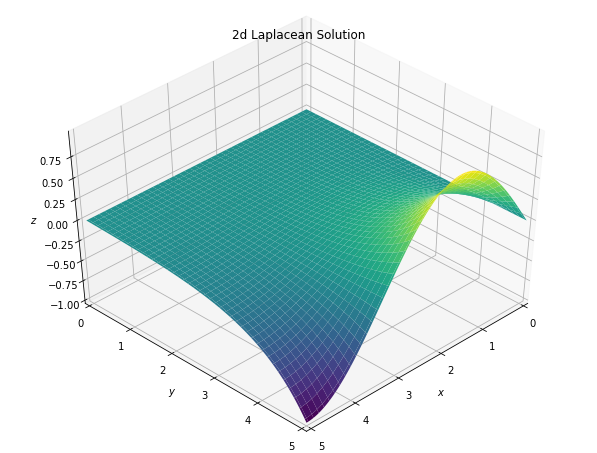

In [2]:
import numpy
from matplotlib import pyplot
from mpl_toolkits import mplot3d
from matplotlib import cm
from numba import jit
from time import perf_counter

def plot_3d(x, y, p, label='$z$', elev=45.0, azim=45.0):

    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    ax.set_title("2d Laplacean Solution")
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, p, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

@jit(nopython=True)    
def laplace_solution(x, y, Lx, Ly):

    X, Y = numpy.meshgrid(x, y)
    p = (numpy.sinh(1.5 * numpy.pi * Y / Ly) /
         numpy.sinh(1.5 * numpy.pi * Ly / Lx) *
         numpy.sin(1.5 * numpy.pi * X / Lx))
    return p

# Parameters.
nx = 128  # no. x 
ny = 128  # no. y
Lx = 5.0  # x Length
Ly = 5.0  # y Length
dx = Lx / (nx - 1)  # x spacing
dy = Ly / (ny - 1)  # y spacing

# grid
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# initial conditions.
p0 = numpy.zeros((ny, nx))
p0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)


@jit(nopython=True)
def laplace(p0, omega, maxiter=20000, rtol=1e-6):

    """
    Outputs
    p    - Solution
    it  - no. of iterations 
    conver - convergence record
    """
    ny, nx = p0.shape
    p = p0.copy()
    conver = []  # convergence record
    diff = rtol + 1.0  
    it = 0  
    while diff > rtol and it < maxiter:
        pn = p.copy()
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = ((1.0 - omega) * p[j, i] +
                           omega * 0.25 *(p[j, i - 1] + p[j, i + 1] +
                                          p[j - 1, i] + p[j + 1, i]))
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conver.append(diff)
        it += 1
    return p, it, conver


print("###Warning, if you dont see a graph please click run again.###")
t1= perf_counter()
# optimised over relaxation
omega = 2.0 / (1.0 + numpy.pi / nx)
p, it, conver_opt_sor = laplace(p0, omega,
                                       maxiter=25000, rtol=1e-13)
t2= perf_counter()
print("Taking",t2-t1,"seconds.")
print("Iterations =",it,"for an accuracy of",conver_opt_sor[-1])

plot_3d(x, y, p)

**Use this cell to describe any choices made in designing your code**

Verify your function by checking it works in a simple, known case. Compare the solution found with the analytical solution and quantify the differences. Use this to investigate the sensitivity of your solution to the choice of grid density and convergence condition.

In [2]:
#See above

The system will reach equilibrium only as the number of iterations tends to ∞, but we can approximate the equilibrium state by iterating until the change between one iteration and the next is very small. The Jacobi and Gauss-seidel method take many iterations to coverge[1] so I decided to use the Successive Over-Relaxation method. In hindsight, the Chebyshev method converges for less steps than SOR and should have been used instead. The Jacobi method requires the most iterations to converge but is the easiest to understand.

If any two functions are solutions to Laplace's equation, their sum (or any linear combination) is also a solution.I would like to sum up multiple Laplacean solutions to see if they obey the superposition principle. 

I considered using a final smoothing function from  Matplotlib and then came across Laplace Interpolation which can be used for restoring missing data on a grid. Laplace’s equation is an "interpolator" as it minimizes the integrated square of the gradient.[2] Even for 90% missing data an image can often be recovered using Laplacean interpolation. This method will require more steps than the Conjugate Gradient method but I could not get that the more complicated CG method working.

Video frame interpolation methods first estimate optical flow between input frames and then use Neural Network Interpolation via convolution.[3] For a highly oscillatory solution a shooting method may be more efficient requiring many fewer grid points. The relaxation method has been sped up by using “over relaxation”[4]. At each point on the grid, ∆V is multiplied by some factor α, and add the result to the original to get the new value of V at that point. In equation form, Vnew = α∆V + Vold.


## 1b)
Now use your function to calculate the potential and electric field within and around a parallel plate capacitor comprising a pair of plates of length a, separation d. Demonstrate that the field configuration approaches the “infinite” plate solution (E = V/d between plates, E = 0 elsewhere) as the ratio of  becomes large.
## Solving the 2d Poisson Equation with 1st order Jacobi Steps

Taking 4.231419199999891 seconds for 200 iterations.


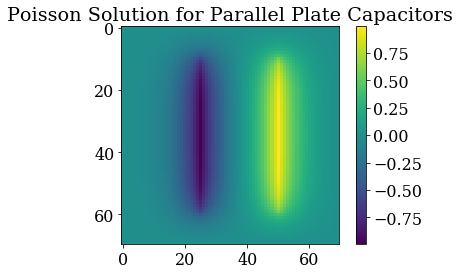

(Check) Max value = 0.9904916578622647


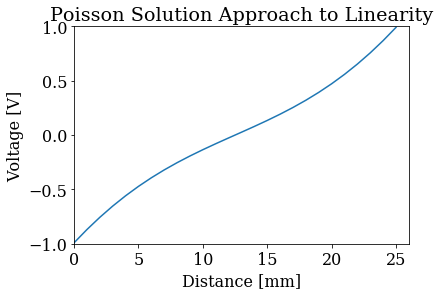

In [33]:
n= 70
rho= numpy.zeros((n,n)) # gridpoints
rho[10:60,25] = -numpy.ones(50)
rho[10:60,50] = numpy.ones(50)

V2= numpy.zeros((n,n)) # gridpoints
h = 0.5
V= numpy.zeros((n,n))


def poisson_solution(steps):
  Vdiff1 = numpy.zeros((n,n))  
  Vdiff2 = numpy.zeros((n,n))
  for dt in range(0,steps):
    V[:] = V2[:]
    for i in numpy.arange(1,(n-1)):
      for j in numpy.arange(1,(n-1)):
          if V2[i,j] ==1 or V2[i,j] == -1:
                
                pass
          else:
            V2[i,j]=(1/4)*(V[i-1,j]+V[i+1,j]+V[i,j-1]+V[i,j+1])+(rho[i,j]*h**2)/4
    
    if dt%10 == 0:
        
        Vdiff2 = numpy.round_(V2, decimals=4)
        if numpy.array_equal(Vdiff1, Vdiff2) == True:
          print("converged for dt =",dt)
          break
        else:
          Vdiff1=Vdiff2
       
        
steps = 200          
t1= perf_counter()            
poisson_solution(steps)            
t2= perf_counter()
print("Taking",t2-t1,"seconds for",steps,"iterations.")


def heatmap2d(arr: numpy.ndarray):
    pyplot.imshow(arr, cmap='viridis')
    pyplot.title("Poisson Solution for Parallel Plate Capacitors")
    pyplot.colorbar()
    pyplot.show()

    
heatmap2d(V2)
section= V2[35,25:51]
x= numpy.arange(26)
pyplot.figure(figsize=(6.0, 4.0))
print("(Check) Max value =",numpy.amax(V2))
pyplot.title("Poisson Solution Approach to Linearity")
pyplot.xlabel('Distance [mm]')
pyplot.ylabel('Voltage [V]')
pyplot.plot(x, section)
pyplot.xlim(0,26)
pyplot.ylim(-1, 1);

This is a static solution to the Poisson Equation. The convergence conditions are checked every 10 steps here ( this is suitable if convergence is expected to take many steps. The second graph shows this first-order iteration method is approaching the expected linear solution without oscillating and thus it is clear over relaxation would speed up this convergence. 1a shows how to solve an elliptical equation properly and 1b shows why not the use the Jacobi method. The solution only converges for h<1 and this would be interesting to examine further.

# Q2 - The Diffusion Equation

Solving the diffusion equation 

$$\alpha \nabla^2 \phi = \frac{\partial \phi}{\partial t}$$

is mathematically similar to solving the Poisson equation. The technique will be to start from known initial conditions and use finite difference equations to propagate the node values forwards in time (subject to any boundary conditions).

A first try using Equation 1 above gives the finite difference form:

$$\frac{\phi′(x_i) − \phi(x_i)}{\delta t} = \frac{\alpha}{h^2} [\phi (x_{i−1}) + \phi(x_{i+1}) − 2\phi(x_i)]$$

Here the values, $\phi$, at three neighbouring points at a time t are used to evaluate the value $\phi`$ at the next time step, $t + \delta t$. This is known as a forward-time or explicit method. Unfortunately, this methood is known to be unstable for certain choices of $h$ and $\delta t$.

A stable alternative is obtained by using the equivalent backward-time or implicit equation:

$$\frac{\phi'(x_i) - \phi(x_i)}{\delta t} = \frac{\alpha}{h^2} [\phi'(x_{i-1}) + \phi'(x_{i+1}) -  2\phi'(x_i)] $$

Now the spatial derivative on the right-hand side needs to be evaluated at $t + \delta t$, which may appear problematic as the $\phi(x)$ values are known while the updated $\phi′(x)$ values are not. Fortunately Equation 3 can be written explicitly in matrix form and solved using the methods explored in Assignment 1.


## 2a)
An iron poker of length 50 cm is initially at a temperature of 20 C. At time t = 0, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Ignoring heat losses along the length of the poker, calculate the temperature distribution along it as a function of time. You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K and its density as 7,900 kg/m3.

Your solution should apply the implicit finite difference method above. It is also recommended that you use an appropriate linear algebra routine from numpy/scipy. You should find ways to verify your results, and quantify the uncertainties due to the method. Discuss your results in the text box below.

## Solving the 1d Diffusion Equation with 1st Order Implicit Steps

Taking 1.2606179000000068 seconds.


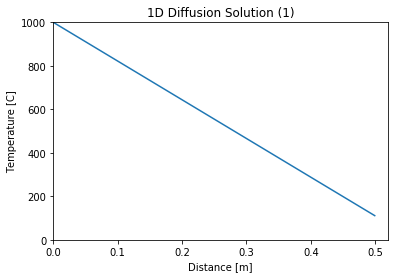

In [3]:
from scipy import linalg
# parameters
L = 0.5+0.02  # length of the rod
nx = 51  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations

kk = 59 #W/m/K thermal_conductivity
cc = 450 #J/kg/K specific_heat
pp = 7900 #kg/m3 density 
alpha=(kk/cc*pp)/1000**2 #  thermal diffusivity of the rod

q = 0.0  # temperature gradient on the right side of the rod

# Define the locations along the rod.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial temperature along the rod.

T0 = 20*numpy.ones(nx)
T0[0] = 1000.0
T0[-1] = 0.0



@jit(nopython=True)
def left(N, sigma):

    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    D[-1, -1] = 1.0 + 1.0 / sigma
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    A = D + U + L
    return A

@jit(nopython=True)
def right(T, sigma, qdx):

    b = T[1:-1] / sigma
    b[0] += T[0]
    b[-1] += qdx
    return b



def implicit0(T0, nt, dt, dx, alpha, q):

    sigma = alpha * dt / dx**2
    A = left(len(T0) - 2, sigma)
    T = T0.copy()
    for n in range(nt):
        b = right(T, sigma, q * dx)
        T[1:-1] = linalg.solve(A, b)
        T[-2] = T[-1] + q * dx
    return T


sigma = 5.0
dt = sigma * dx**2 / alpha  
nt = 2000  


t1= perf_counter()
T = implicit0(T0, nt, dt, dx, alpha, q)
t2= perf_counter()
print("Taking",t2-t1,"seconds.")

pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.title("1D Diffusion Solution (1)")
pyplot.plot(x[0:-2], T[0:-2])
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 1000.0);

Both ends of the rod are in an infinite heat reservoir. Iteration is required to meld these spatially scattered boundary conditions into a single global solution of the partial differential equation. It would be more efficient to use scipy.sparse.linalg.spsolve as the matrices are diagonal. I decided that the rod is perfectly insulated and that the material is uniform. It would be interesting to account for the radiative loss of the rod According to the Stefan–Boltzmann law.

The boundary conditions for this parabolic PDE work here but they are messy, however, the goal of numerical simulations is not always accuracy but sometimes staying true to the underlying physics.

## 2b)
Now repeat the calculation, but assume the far end of the poker from the furnace is no longer held at 0 C, and experiences no heat loss. You will need to modify your code to achieve this, and you should discuss the motivation for your changes below.

## Solving the 1d Diffusion Equation with 1st Order Implicit Steps

Taking 0.07611980000001495 seconds.


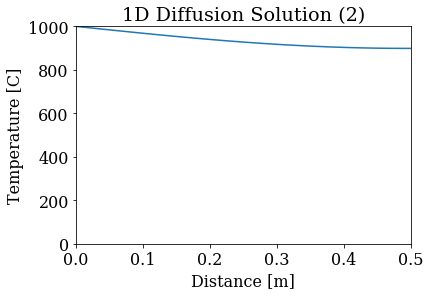

In [46]:
# Set parameters
L = 0.5  
nx = 51 
dx = L / (nx - 1)  
kk = 59 #W/m/K thermal_conductivity
cc = 450 #J/kg/K specific_heat
pp = 7900 #kg/m3 density 
alpha=(kk/cc*pp)/1000**2 #  thermal diffusivity of the rod
q = 0.0  

x = numpy.linspace(0.0, L, num=nx)
T0 = 20*numpy.ones(nx)
T0[0] = 1000.0


def implicit1(T0, nt, dt, dx, alpha, q):

    sigma = alpha * dt / dx**2
    A = left(len(T0) - 2, sigma)
    T = T0.copy()
    for n in range(nt):
        b = right(T, sigma, q * dx)
        T[1:-1] = linalg.solve(A, b)
        T[-1] = T[-2] + q * dx
    return T

sigma = 5.0
dt = sigma * dx**2 / alpha  
nt = 500  # no. steps
t1= perf_counter()
T = implicit1(T0, nt, dt, dx, alpha, q)
t2= perf_counter()
print("Taking",t2-t1,"seconds.")

pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.title("1D Diffusion Solution (2)")
pyplot.plot(x, T)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 1000.0);

#Add swtich off for ~1000

An non-final iteration is shown here as it offers more to the reader than a straight line at 1000C.

## Extensions

There are many possible extensions to this assignment, for example :
* Model the field in more complex arrangements than the parallel plate capacitor in 1b).
* Model a point charge using the code from Q1? What are the problems/challenges in doing so ?
* Demonstrate that the explicit method in Q2 is unstable for some choices of $\delta t$ and $h$.
* Implement higher-order methods (eg. Crank-Nicolson, which includes a 2nd order difference for the spatial derivative).

## Solving the 1d Diffusion Equation with 2nd Order Implicit Steps

You are advised to discuss any extensions with your demonstrator or the unit director.  If you wish to include any extensions, please do so *below* this cell.

Taking 0.016432200000053854 seconds.


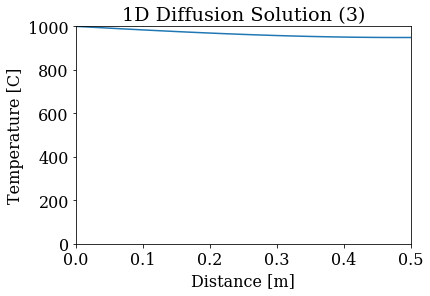

In [47]:
from scipy import linalg


def CN(T0, nt, dt, dx, alpha, q):

    sigma = alpha * dt / dx**2
    A = left(len(T0) - 2, sigma)
    T = T0.copy()
    for n in range(nt):
        b = right(T, sigma, q * dx)
        T[1:-1] = linalg.solve(A, b) #Solving matrix
        T[-1] = T[-2] + q * dx
    return T


# Set parameters
L = 0.5  # length of the rod
nx = 21  
dx = L / (nx - 1)  
kk = 59 #W/m/K thermal_conductivity
cc = 450 #J/kg/K specific_heat
pp = 7900 #kg/m3 density 
alpha=(kk/cc*pp)/1000**2 #  thermal diffusivity of the rod
q = 0.0  

x = numpy.linspace(0.0, L, num=nx) # rod points
T0 = 20*numpy.ones(nx)
T0[0] = 1000.0
sigma = 5.0
dt = sigma * dx**2 / alpha  
nt = 100  # no. steps

t1= perf_counter()
T = CN(T0, nt, dt, dx, alpha, q)
t2= perf_counter()
print("Taking",t2-t1,"seconds.")

pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.title("1D Diffusion Solution (3)")
pyplot.plot(x, T)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 1000.0);

When used Spectral method to approach the analytical Fourier series for a system it's helpful to know that for the following types of PDE's:
Elliptic: the eigenvalues are all positive or all negative.
Parabolic: the eigenvalues are all positive or all negative, save one that is zero.
Hyperbolic: there is only one negative eigenvalue and all the rest are positive, or there is only one positive eigenvalue and all the rest are negative.
Ultrahyperbolic: there is more than one positive eigenvalue and more than one negative eigenvalue, and there are no zero eigenvalues. There is only a limited theory for ultrahyperbolic equations (Courant and Hilbert, 1962

Automated reduction in the number of grid points or an adaptive mesh as the solution reaches a steady-state is commonplace in computation physics but I have avoided that for simplicity.[4]

## Referances

[1]Computational Physics,David Potter, Wiley,1973,p110
[2] Daisuke Kiku, Yusuke Monno, Masayuki Tanaka, and Masatoshi Okutomi "Minimized-Laplacian residual interpolation for color image demosaicking", Proc. SPIE 9023, Digital Photography X, 90230L (7 March 2014); https://doi.org/10.1117/12.2038425

[3] Simon Niklaus, Long Mai and Feng Liu "Video Frame Interpolation via Adaptive Separable Convolution", arXiv, 1708.01692 (2017);

[4] Ryoichi Ando, Nils Thürey and Chris Wojtan. ACM Tans. Graph. (SIGGRAPH 2013);
